# Moment of truth for Mobydick

In this notebook we assess the performance of a Binary classifier trained on Whale sounds.  

Mobydick is a deep learning classifier that we trained to determine whether a given 3-second audio clip contains a North Atlantic right whale (NARW) upcall. 

Our goal is now to transform this classifier into a detector that can analyze an audio file (.wav) of an arbitrary duration (e.g. 30 min) and tell us where within that file upcalls occur.

Intuitively, the solution to this problem is straightforward: Simply slide a 3-s wide window across the audio file and use the classifier to determine if an upcall is present within the window at any given instant. However, as you try to implement this solution, you immediately run into a number of practical questions. For example, how large steps should we take when sliding the window?

In this notebook, we will outline a few different strategies to implement the sliding-window approach. Ultimately, however, all will depend on what strategy we can adapt on the IoT devices.

##Importing Packages and Libraries

In [ ]:
!pip install ketos

In [2]:
import os

In [3]:
import pandas as pd
import ketos.neural_networks.dev_utils.detection as det
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioFrameLoader
from ketos.neural_networks.resnet import ResNetInterface
from ketos.neural_networks.dev_utils.detection import process, save_detections
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
from google.colab import files
moby = files.upload()

Saving Mobydick_new2.kt to Mobydick_new2.kt


In [6]:
#importing the model
model, audio_repr = ResNetInterface.load_model_file(model_file='/content/Mobydick_new2.kt', new_model_folder='./moby_tmp_folder', load_audio_repr=True)

In [7]:
#inspecting spectrogram parameters
spec_config = audio_repr[0]['spectrogram']
spec_config

{'duration': 3.0,
 'freq_max': 500,
 'freq_min': 0,
 'rate': 1000,
 'step': 0.032,
 'type': 'MagSpectrogram',
 'window': 0.256,
 'window_func': 'hamming'}

We use 3 audio files that were recorded in the Gulf of St. Lawrence in the summer of 2016 by Meridian. They are named sample_1.wav, sample_2.wav, and sample_3.wav, contain a total of 26 NARW upcalls. Each file is 30 minute long. We will be using these data to test the performance of our detector.


In [8]:
#retrieving the sound files:
!wget https://gitlab.meridian.cs.dal.ca/public_projects/ketos_tutorials/-/raw/master/tutorials/create_a_narw_detector/data.zip

--2021-12-07 21:35:33--  https://gitlab.meridian.cs.dal.ca/public_projects/ketos_tutorials/-/raw/master/tutorials/create_a_narw_detector/data.zip
Resolving gitlab.meridian.cs.dal.ca (gitlab.meridian.cs.dal.ca)... 206.12.88.81
Connecting to gitlab.meridian.cs.dal.ca (gitlab.meridian.cs.dal.ca)|206.12.88.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248622599 (237M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 237.10M  42.4MB/s    in 6.1s    

2021-12-07 21:35:40 (39.2 MB/s) - ‘data.zip’ saved [248622599/248622599]



In [9]:
!unzip -q data.zip

The time of occurrence of the upcalls is listed in the file annotations.csv. 

In [10]:
annot = pd.read_csv('/content/data/annotations.csv', sep=';')
print(annot)

      sound_file  call_time
0   sample_1.wav   1128.840
1   sample_1.wav   1153.526
2   sample_1.wav   1196.778
3   sample_1.wav   1227.642
4   sample_1.wav   1358.181
5   sample_1.wav   1437.482
6   sample_1.wav   1489.288
7   sample_1.wav   1511.670
8   sample_1.wav   1530.595
9   sample_1.wav   1536.580
10  sample_1.wav   1714.372
11  sample_1.wav   1768.251
12  sample_1.wav   1777.835
13  sample_2.wav     68.149
14  sample_2.wav    688.507
15  sample_2.wav    755.940
16  sample_2.wav    770.440
17  sample_3.wav     68.853
18  sample_3.wav    105.927
19  sample_3.wav   1057.015
20  sample_3.wav   1067.282
21  sample_3.wav   1290.563
22  sample_3.wav   1378.955
23  sample_3.wav   1428.648
24  sample_3.wav   1663.622
25  sample_3.wav   1676.682


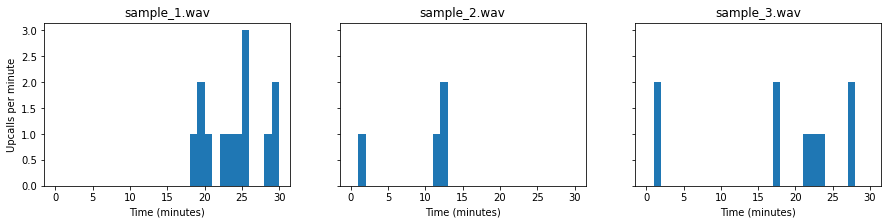

In [11]:
#vizualizing the temporal placement of the upcalls
fig, axes = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

for i in range(3):
    filename = f'sample_{i+1}.wav' #filename
    values = annot[annot['sound_file']==filename]['call_time'].values / 60  #select the occurrence times for this file, and convert from seconds to minutes
    axes[i].hist(values, bins=30, range=(0,30)) #plot the data in a histogram
    axes[i].set_xlabel('Time (minutes)') #set axes labels and title
    if i==0: axes[i].set_ylabel('Upcalls per minute')
    axes[i].set_title(filename)

Upcalls seem to have a tentency to cluster. 

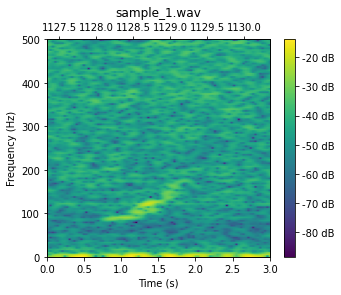

In [12]:
# compute the spectrogram of the 1st upcall, using the spectrogram parameters loaded from the saved model
spec = MagSpectrogram.from_wav(path='/content/data/audio/sample_1.wav', 
                               offset=1128.840 - 0.5*spec_config['duration'],
                               **spec_config)

spec.plot() #create the figure
plt.show()  #display it!

In [13]:
#Loading data frame by frame
audio_loader = AudioFrameLoader(path='/content/data/audio/', step=1.5, repres=spec_config)

In [14]:
first_spec = next(audio_loader) #load the first 3.0-s frame
second_spec = next(audio_loader) #load the second 3.0-s frame
# etc

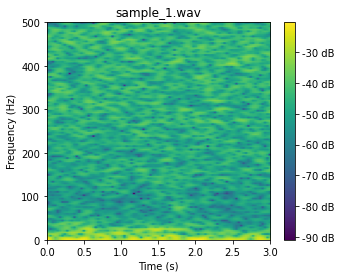

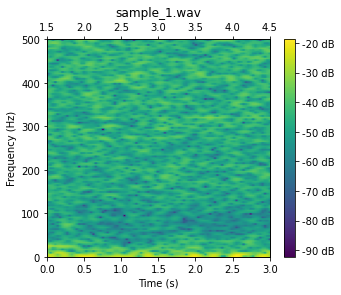

In [15]:
first_spec.plot()
second_spec.plot()
plt.show()

In [16]:
print(audio_loader.num()) #how many frames are there?

3600


In [17]:
#resets the audio loader to the 1st frame
audio_loader.reset()

## Feeding the frames to the classifier

In [18]:
#Feeding the frames to the classifier
spec = next(audio_loader) #load a spectrogram
data = spec.get_data()    #extract the pixel values as a 2d array
output = model.run_on_instance(data) #pass the pixel values to the classifier
print(output) #print the classifier's output

(array([1]), array([0.90460664], dtype=float32))


In [19]:
label = output[0][0]
score = output[1][0]
print(f'label: {label}')
print(f'score: {score}')

label: 1
score: 0.9046066403388977


##The Process method:

In [20]:
audio_loader.reset() #reset the audio loader before processing
detections = process(audio_loader, model=model, batch_size=64, progress_bar=True)

100%|██████████| 56/56 [01:51<00:00,  1.99s/it]


In [21]:
for d in detections[:6]:
    print(d)

('sample_1.wav', 0.0, 3.008, 0.90460664)
('sample_1.wav', 1.5, 3.008, 0.9545331)
('sample_1.wav', 3.0, 3.008, 0.95787114)
('sample_1.wav', 4.5, 3.008, 0.952437)
('sample_1.wav', 6.0, 3.008, 0.9154281)
('sample_1.wav', 7.5, 3.008, 0.9494029)


In [22]:
detections_grp = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True)

100%|██████████| 56/56 [01:47<00:00,  1.92s/it]


In [23]:
print(len(detections_grp))

94


In [24]:
detections_grp_t07 = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.7)

100%|██████████| 56/56 [01:48<00:00,  1.94s/it]


In [25]:
print(len(detections_grp_t07))

60


In [26]:
detections_grp_t055_avg = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.55, win_len=5)

100%|██████████| 56/56 [01:53<00:00,  2.02s/it]


In [28]:
print(len(detections_grp_t055_avg))

37


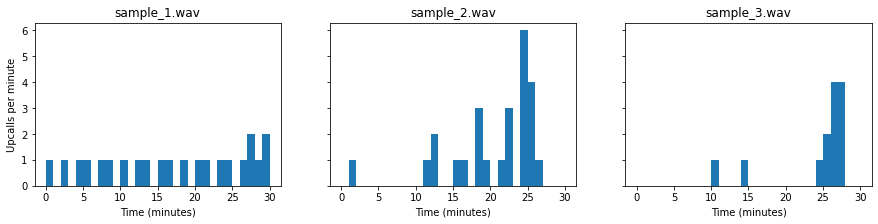

In [29]:
#Visualizing the temporal distribution of the detections:
fig, axes = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

for i in range(3):
    filename = f'sample_{i+1}.wav' #filename
    values = [(d[1]+0.5*d[2])/60. for d in detections_grp_t07 if d[0]==filename]  #mid-point of detection in minutes
    axes[i].hist(values, bins=30, range=(0,30)) #plot the data in a histogram
    axes[i].set_xlabel('Time (minutes)') #set axes labels and title
    if i==0: axes[i].set_ylabel('Upcalls per minute')
    axes[i].set_title(filename)

In [30]:
save_detections(detections=detections, save_to='detections.csv')

In [34]:
#Define a function that compares the upcalls found by the model (detections)
#with the upcalls identified by the human expert (annotations).
#The function returns the annotation DataFrame with an extra boolean 
#column indicating if a given annotated upcall was detected by the model.
def compare(annotations, detections):

    detected_list = []

    for idx,row in annotations.iterrows(): #loop over annotations
        filename_annot = row['sound_file']
        time_annot = row['call_time']
        detected = False
        for d in detections: #loop over detections
            filename_det = d[0]
            start_det    = d[1]
            end_det      = start_det + d[2]
            # if the filenames match and the annotated time falls with the start and 
            # end time of the detection interval, consider the call detected
            if filename_annot==filename_det and time_annot >= start_det and time_annot <= end_det:
                detected = True
                break

        detected_list.append(detected)       

    annotations['detected'] = detected_list  #add column to the annotations table
    
    return annotations

#call the function
annot = compare(annot, detections_grp_t07)

print(annot)    

      sound_file  call_time  detected
0   sample_1.wav   1128.840      True
1   sample_1.wav   1153.526      True
2   sample_1.wav   1196.778      True
3   sample_1.wav   1227.642      True
4   sample_1.wav   1358.181      True
5   sample_1.wav   1437.482      True
6   sample_1.wav   1489.288      True
7   sample_1.wav   1511.670      True
8   sample_1.wav   1530.595      True
9   sample_1.wav   1536.580      True
10  sample_1.wav   1714.372      True
11  sample_1.wav   1768.251      True
12  sample_1.wav   1777.835      True
13  sample_2.wav     68.149      True
14  sample_2.wav    688.507     False
15  sample_2.wav    755.940      True
16  sample_2.wav    770.440      True
17  sample_3.wav     68.853     False
18  sample_3.wav    105.927     False
19  sample_3.wav   1057.015     False
20  sample_3.wav   1067.282     False
21  sample_3.wav   1290.563     False
22  sample_3.wav   1378.955     False
23  sample_3.wav   1428.648     False
24  sample_3.wav   1663.622     False
25  sample_3

In [32]:
annot = compare(annot, detections_grp_t055_avg)

print(annot)

      sound_file  call_time  detected
0   sample_1.wav   1128.840      True
1   sample_1.wav   1153.526      True
2   sample_1.wav   1196.778      True
3   sample_1.wav   1227.642      True
4   sample_1.wav   1358.181      True
5   sample_1.wav   1437.482      True
6   sample_1.wav   1489.288      True
7   sample_1.wav   1511.670      True
8   sample_1.wav   1530.595      True
9   sample_1.wav   1536.580      True
10  sample_1.wav   1714.372      True
11  sample_1.wav   1768.251      True
12  sample_1.wav   1777.835      True
13  sample_2.wav     68.149     False
14  sample_2.wav    688.507     False
15  sample_2.wav    755.940     False
16  sample_2.wav    770.440     False
17  sample_3.wav     68.853     False
18  sample_3.wav    105.927     False
19  sample_3.wav   1057.015     False
20  sample_3.wav   1067.282     False
21  sample_3.wav   1290.563     False
22  sample_3.wav   1378.955     False
23  sample_3.wav   1428.648     False
24  sample_3.wav   1663.622     False
25  sample_3